# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [68]:
print("the number of rows in df dataframe is {}".format(df.shape[0]))

the number of rows in df dataframe is 45993


In [69]:

print("the number of rows in df_content dataframe is {}".format(df_content.shape[0]))

the number of rows in df_content dataframe is 1051


In [73]:
no_unique_user = df.email.nunique()
print("the number of unique users is {}".format(no_unique_user))

the number of unique users is 5148


In [75]:
unique_articles = df_content.article_id.nunique()
print("the number of unique articles is {}".format(unique_articles))

the number of unique articles is 1051


In [80]:
print('the number of nulls in each column of df dataframe')
df.isnull().sum(axis=0)

the number of nulls in each column of df dataframe


article_id     0
title          0
email         17
dtype: int64

In [81]:
print('the number of nulls in each column of df_content dataframe')
df_content.isnull().sum(axis=0)

the number of nulls in each column of df_content dataframe


doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [94]:
#find the top most read articles

print('Top 10 most read articles')
df.title.value_counts().reset_index(name='title').rename(columns={'title':'reads'})[:10]

Top 10 most read articles


,index,reads
0,use deep learning for image classification,937
1,insights from new york car accident reports,927
2,visualize car data with brunel,671
3,"use xgboost, scikit-learn & ibm watson machine...",643
4,predicting churn with the spss random tree alg...,627
5,healthcare python streaming application demo,614
6,finding optimal locations of new store using d...,572
7,"apache spark lab, part 1: basic concepts",565
8,analyze energy consumption in buildings,512
9,gosales transactions for logistic regression m...,483


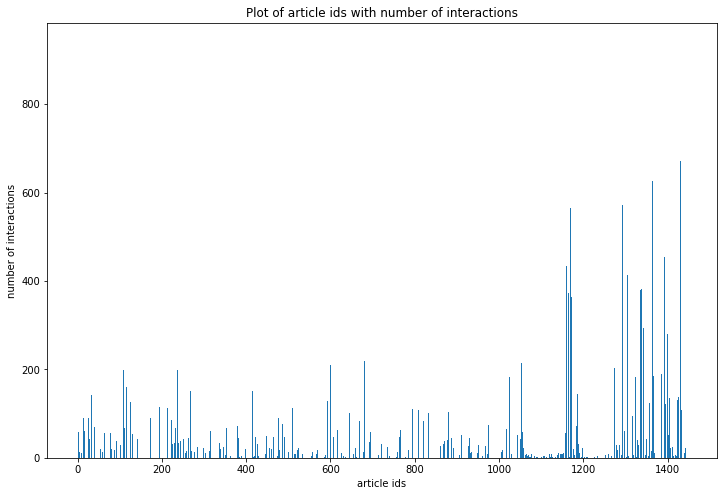

In [107]:
# plot the number of reads for the articles
article_read = df.article_id.value_counts().reset_index()

plt.figure(figsize=(12,8))

plt.bar(article_read['index'],article_read['article_id']);
plt.title('Plot of article ids with number of interactions');
plt.xlabel('article ids');
plt.ylabel('number of interactions');

from the graph, it looks like the higher article number, the higher the number of reads or interactions

In [138]:
# let's look at both data set and find whether article ids are missing

# find the article ids that do not have content 
no_content = df_content[~df_content.article_id.isin(df.article_id.tolist()) ].shape[0]

print('the number of articles with no concent is {}'.format(no_content))

the number of articles with no concent is 615


In [139]:
print('the number of articles with  concent is {}'.format(df_content.shape[0] - no_content ))

the number of articles with  concent is 441


In [125]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.email.value_counts().median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =df.email.value_counts().head(1).values[0]  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles


# explore duplicated doc_body
df_content[df_content.doc_body.duplicated()].shape[0]

19

In [7]:
# explore duplicated doc_body
df_content[df_content.doc_full_name.duplicated()].shape[0]

5

In [8]:
# explore duplicated doc_body
df_content[df_content.doc_description.duplicated()].shape[0]

33

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id', keep = 'first')
df_content.shape[0]

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [142]:
total_unique_art = df_content.article_id.nunique()

print('the total number of articles is {}'.format(total_unique_art))

the total number of articles is 1051


In [143]:
unique_art = df.article_id.nunique()

print('the  number of unique articles is {}'.format(unique_art))

the  number of unique articles is 714


In [141]:
unique_users =len( df.email.unique())

print('the number of unique users is {}'.format(unique_users))

the number of unique users is 5149


In [144]:
article_ineraction =df.shape[0]
print('the number of user-article interactions is {}'.format(article_ineraction))

the number of user-article interactions is 45993


In [149]:
print('Mean article interactions is {}'.format(df.article_id.value_counts().mean()))

Mean article interactions is 64.41596638655462


In [150]:
print('Median article interactions is {}'.format(df.article_id.value_counts().median()))

Median article interactions is 25.0


In [151]:
print('Mean user interactions is {}'.format(df.email.value_counts().mean()))

Mean user interactions is 8.930846930846931


In [152]:
print('Median user interactions is {}'.format(df.email.value_counts().median()))

Median user interactions is 3.0


In [14]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users =  df.email.nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
article_views =  df.title.value_counts().reset_index(name='number_of_interaction').rename(columns ={'index': 'title'})

In [16]:
article_views[:5]

,title,number_of_interaction
0,use deep learning for image classification,937
1,insights from new york car accident reports,927
2,visualize car data with brunel,671
3,"use xgboost, scikit-learn & ibm watson machine...",643
4,predicting churn with the spss random tree alg...,627


In [161]:
most_viewed = article_views[article_views.number_of_interaction == article_views.number_of_interaction.max()]

In [165]:
max_most_viewed = most_viewed['number_of_interaction'].values[0]

In [167]:
print('the maximum number of most viewed article is {}'.format(max_most_viewed) )

the maximum number of most viewed article is 937


In [156]:
mst_viewed_title = most_viewed['title'].values[0]

print('most viewed article is [{}]'.format(mst_viewed_title))

most viewed article is [use deep learning for image classification]


In [21]:
mst_viewed_article_id = df[df.title == mst_viewed_title].article_id.unique()[0]

In [22]:
mst_viewed_article_id

1429.0

In [23]:
most_viewed_article_id = str(mst_viewed_article_id) # The most viewed article in the dataset as a string with one value following the decimal 
max_views =max_most_viewed # The most viewed article in the dataset was viewed how many times?

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [26]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    idx = df.article_id.value_counts().sort_values(ascending = False).head(n).index
    top_articles = df[df.article_id.isin(idx)]['title'].unique()


    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.article_id.value_counts().head(n).index.astype(str).tolist()
 
    return top_articles # Return the top article ids

In [27]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings' 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [29]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [30]:
new_df = df[['user_id', 'article_id']]
new_df['value'] = 1
new_df = new_df.groupby(['user_id', 'article_id']).max().unstack()
new_df.fillna(0, inplace = True)


new_df.head()

value                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...                                                     \
article_id 18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                      
1             0.0  ...      0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...      0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

In [31]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    
    df = df[['user_id', 'article_id']]
    df['value'] = 1
    df = df.groupby(['user_id', 'article_id']).max().unstack()
    df.fillna(0,inplace=True)
    user_item = df
    
    
    
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user

    
    # find row of each user
    idx = np.where(user_item.index == user_id)[0][0]
    # compute similarity of each user to the provided user
    dot_prod = user_item.dot(np.transpose(user_item))
    similar = dot_prod.iloc[idx].sort_values(ascending = False)

    # sort by similarity
    similar = similar[similar.values > 0]
    # create list of just the ids
    similar = similar.index.drop(user_id)
    # remove the own user's id
    most_similar_users = similar.tolist()
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [34]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
 
    article_id = map(float, article_ids)
   
    article_names = []
    
    for id in article_id:

        n = np.unique(np.array(df[df.article_id.isin([id])]['title']))[0]
        article_names.append(str(n))

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    article_ids = set((user_item.loc[user_id][user_item.loc[user_id].values == 1]\
                   .value.index.sort_values(ascending=True).astype(str) ).tolist())

    article_names = get_article_names(article_ids)
    
    
    return [article_ids, article_names] # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    similar = find_similar_users(user_id)
    user_art_id, user_art_name = get_user_articles(user_id)
    
    recs = np.array([])
    

    for user in similar:
        sim_id, sim_name = get_user_articles(user)
        new_recs = list(np.setdiff1d(sim_id, user_art_id, assume_unique = True)[0])
        
        recs = np.unique(np.concatenate([new_recs,recs], axis=None) )
        
        if len(recs) > (m - 1):
            break
    
    
    return recs # return your recommendations for this user_id    

In [36]:
user_user_recs(1, 10)

array(['1052.0', '109.0', '1170.0', '1183.0', '1185.0', '1232.0', '1293.0',
       '1305.0', '1363.0', '1368.0', '1391.0', '1400.0', '1406.0',
       '1427.0', '1429.0', '1430.0', '1431.0', '1436.0', '1439.0', '268.0',
       '310.0', '329.0', '346.0', '390.0', '43.0', '494.0', '525.0',
       '585.0', '626.0', '668.0', '732.0', '768.0', '910.0', '968.0',
       '981.0'], 
      dtype='<U32')

In [37]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['access db2 warehouse on cloud and db2 with python',
 'tensorflow quick tips',
 'apache spark lab, part 1: basic concepts',
 'categorize urban density',
 'classify tumors with machine learning',
 'country statistics: life expectancy at birth',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for naive bayes model',
 'predict loan applicant behavior with tensorflow neural networking',
 'putting a human face on machine learning',
 'sudoku',
 'uci ml repository: chronic kidney disease data set',
 'uci: iris',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'use deep learning for image classification',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'visualize car data with brunel',
 'welcome to pixiedust',
 'working with ibm cloud object storage in r',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)',
 'introduction to market basket analy

In [38]:
get_user_articles(2)[0]

{'1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'}

In [39]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [40]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    
    dot_prod_articles = user_item.dot(np.transpose(user_item))
    sim = dot_prod_articles.loc[user_id].sort_values(ascending = False)
    sim = sim.to_frame().reset_index().drop(0, axis =0)
    sim.columns = ['user_id', 'similarity']

    neighbor_counts = pd.Series(df.user_id.value_counts())
    neighbor_counts = neighbor_counts.to_frame().reset_index()
    neighbor_counts.columns = ['user_id', 'user_interactions']

    neighbors_df = pd.merge(sim,neighbor_counts[['user_id','user_interactions']],on='user_id', how='left')
    neighbors_df.columns = ['user_id', 'similarity', 'user_interactions']
    neighbors_df = neighbors_df.sort_values(['similarity', 'user_interactions'], ascending = False).reset_index()
    neighbors_df = neighbors_df.drop('index', axis = 1)


    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    
    recs_list = []
    user_article_id, user_article = get_user_articles(user_id)
    
    for id in get_top_sorted_users(user_id).user_id:
        
        article_id, article = get_user_articles(id)
        art_sum = []
        
        for art_id in article_id:
        
          
            art = user_item['value', float(art_id)].sum()
            art_sum.append(art)
        
        dictionary = {'article_id': article_id, 'art_sum': art_sum}
        sum_art = pd.DataFrame(dictionary)

        sum_art = sum_art.sort_values(by = 'art_sum').reset_index()



        new_recs =  list(np.setdiff1d(sum_art.article_id, user_article_id, assume_unique= True)[0])
        np.unique(recs_list.append(new_recs))
    
    recs_list = np.concatenate(recs_list, axis=0)
    recs = recs_list[:m]
    rec_names = get_article_names(recs)
    
    
    
    return recs, rec_names

In [41]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1335.0' '232.0' '1346.0' '125.0' '142.0' '1426.0' '555.0' '880.0' '651.0'
 '939.0']

The top 10 recommendations for user 20 are the following article names:
['labor', 'self-service data preparation with ibm data refinery', 'military expenditure as % of gdp by country', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'use spark for scala to load data and run sql queries', 'build a naive-bayes model with wml & dsx', 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots', 'analyzing streaming data from kafka topics', 'deep learning from scratch i: computational graphs']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [42]:
### Tests with a dictionary of results

user1_most_sim =  find_similar_users(1)[0]  # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [43]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Recommendation Method for new users.**

Because the user is new to the platform, this is a cold start problem and hence we can either choose to use a ranking based recommendation o a content based recommendation system. 
Therefore the  get_top_articles() function, which is a ranking based recommendation would solve this cold start problem and it is the choice of function to use

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [44]:
get_top_article_ids(10)

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [45]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs =   get_top_article_ids(10) # Your recommendations here



In [46]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [47]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [48]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [49]:
# Perform SVD on the User-Item Matrix Here

u, s, vt =np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**The user item matrix has no NANs so we can use np SVD**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

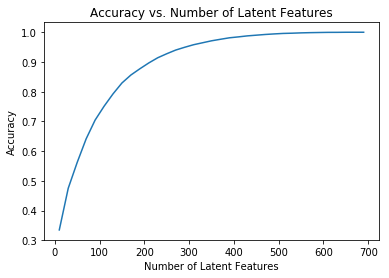

In [50]:
num_latent_feats = np.arange(10,700+10,20)
total_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    total_sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(total_sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [51]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    
    # training set
    df_train = df_train[['user_id', 'article_id']]
    df_train['value'] = 1
    df_train = df_train.groupby(['user_id', 'article_id']).max().unstack()
    df_train.fillna(0, inplace=True)
    user_item_train = df_train
    
    # test set
    df_test = df_test[['user_id', 'article_id']]
    df_test['value'] = 1
    df_test = df_test.groupby(['user_id', 'article_id']).max().unstack()
    df_test = df_test.fillna(0)
    user_item_test = df_test
    
    # user ids
    test_idx = user_item_test.index
    
    # article ids
    test_arts = user_item_test.columns.levels[1]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [52]:

# find users in both train and test set

user_item_train.index.isin(test_idx).sum()


20

In [53]:
len(test_idx) - 20

662

In [54]:
user_item_train.columns.levels[1].isin(test_arts).sum()


574

In [55]:
len(test_arts) - 574

0

In [56]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [57]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [58]:
common_idx = user_item_train.index.isin(test_idx)

In [59]:
common_arts = user_item_train.columns.levels[1].isin(test_arts)

In [60]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

train_ind = user_item_train.index[common_idx]
test_ind = user_item_test.index.isin(train_ind)
test_ind = user_item_test.index[test_ind]
test_ind == train_ind

user_item_test = user_item_test.loc[test_ind]

u_test = u_train[common_idx, :]
vt_test = vt_train[:, common_arts]

In [61]:
num_latent_feats = np.arange(10,700+10,20)

sum_train_errs=[]
sum_test_errs=[]

sum_total_errs = []

for k in num_latent_feats:
    # restructure with k latent features

    u_train_new, s_train_new, vt_train_new = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k,:]
    
    # take dot product
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))

    
    # compute error for each prediction to actual value for both train and test
    
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
   

    train_err = np.sum(np.sum(np.abs(diffs_train)))
    test_err = np.sum(np.sum(np.abs(diffs_test)))
   
    
    # total errors and keep track of them
    sum_train_errs.append(train_err)
    sum_test_errs.append(test_err)
    sum_total_errs.append(1 - ((np.sum(user_item_test_preds)\
                                +np.sum(np.sum(user_item_test)))\
                               /(user_item_test.shape[0]*user_item_test.shape[1])))
    
    


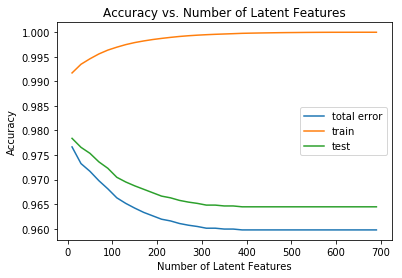

In [66]:

train_ = np.array(sum_train_errs) / (user_item_train.shape[0]*user_item_train.shape[1])
test_ =  np.array(sum_test_errs) / (user_item_test.shape[0]*user_item_test.shape[1])
             
plt.plot(num_latent_feats, sum_total_errs, label='total error');
plt.plot(num_latent_feats, (1 - train_ ), label='train' );
plt.plot(num_latent_feats, (1 - test_), label='test' );

plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

The accuracy of the SVD becomes worse as the amount of latent features increases and this might be due to overfitting.

The number of common users in both the train and test dataset is so few that it is not recommended to use SVD to predict the test dataset. We can user either knowledge based or content based approaches for this cold start problem.

We could deploy the current recommendation engine with an experiment to check if there is an increase in interaction between users and articles for two different groups of users in a A/B test experiment where one group sees the SVD recommendations and another group sees a cold start approach.

The metric to measure the success of the experiment will be the number of articles the user interacts with because that is the original concept of the model built.

In [168]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0